# Credit Card Approval Prediction

## The Problem

Our banking client has tasked us to assess their clients risk in order to automate the credit card application procedures.

We have been provided with two datasets:
1. Dataset of applications records
2. Credit records of existing clients of the bank

Our goal is to develop a machine learning model in order to assess whether an applicant qualifies for a credit card, and therefore whether their application is going to be approved or desclined. To do that we need to assess whether a client holds high or low risk.
Notably, the criteria for categorizing an applicant as 'approved' or 'declined' is unspecified in our data.

## Project Preparation

In [2]:
# Basic data manipulation and visualisation packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data preprocessing packages
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

# Training and evaluation packages
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Ensembles
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# Save the model for later use
import joblib

# Pandas setting for df display
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: f"{x:.2f}")

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Timeit
import time
import timeit

In [3]:
# Load datasets
apl = pd.read_csv("data/application_record.csv", header=0)
crd = pd.read_csv("data/credit_record.csv", header=0)

## Data Exploration

### Application Records

The first dataset (apl) has records of applications people have made to a financial institution for a credit card. It consists of 438.557 records and 18 characteristics the applicants have.

In [4]:
# Dimensions of the application_record dataset
print(f"Dimensions of the dataset: {apl.shape} \n")

Dimensions of the dataset: (438557, 18) 



In [5]:
# Peek at the data
apl.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00
1,5008805,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00
2,5008806,M,Y,Y,0,112500.00,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.00
3,5008808,F,N,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00
4,5008809,F,N,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00


At a first glance the info we have for the applicants are:
- ID (not their actual ID, but an RDBMS one) `ID`

- their gender `CODE_GENDER`,

- whether they own a car `FLAG_OWN_CAR`,

- or any kind of property `FLAG_OWN_REALTY`,

- the number of children they have `CNT_CHILDREN`,

- their total income ammount `AMT_INCOME_TOTAL`,

- the way they obtain said income `NAME_INCOME_TYPE`,

- their level of education `NAME_EDUCATION_TYPE`,

- their marital status `NAME_FAMILY_STATUS`,

- their residence type `NAME_HOUSING_TYPE`,

- the days they're alive until they made the application `DAYS_BIRTH`,

- the days they have been employed until they made the application `DAYS_EMPLOYED`,

- whether they have a registered mobile phone device `FLAG_MOBIL`,

- and number `FLAG_WORK_PHONE`,

- a work phone number `FLAG_PHONE`,

- an email `FLAG_EMAIL`, 

- the type of occupation `OCCUPATION_TYPE`,

- and the number of family members `CNT_FAM_MEMBERS`

The features names are not very intuitive and some of them are most likely not needed (like `FLAG_EMAIL`), but this is the least of our problems for the time being. What is most interesting is that there are already visible some missing values in `OCCUPATION_TYPE` and the fact that `DAYS_BIRTH` and `DAYS_EMPLOYED` have negative values. Other than that, we can already spot some categorical data that are good encoding candidates like `CODE_GENDER`. This will be looked more into later in the Notebook at the Preprocessing section.

In [6]:
# Data types
print(f"Data types:\n{apl.dtypes}")

Data types:
ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
dtype: object


Interesting how the family members count is a float and not an integer.

In [7]:
# Statistical summary of all attributes
print("Statistical summary of all attributes:")
apl.iloc[:,1:].describe().T.iloc[:,1:] # We excluded the ID and the count

Statistical summary of all attributes:


,mean,std,min,25%,50%,75%,max
CNT_CHILDREN,0.43,0.72,0.00,0.00,0.00,1.00,19.00
AMT_INCOME_TOTAL,187524.29,110086.85,26100.00,121500.00,160780.50,225000.00,6750000.00
DAYS_BIRTH,-15997.90,4185.03,-25201.00,-19483.00,-15630.00,-12514.00,-7489.00
DAYS_EMPLOYED,60563.68,138767.80,-17531.00,-3103.00,-1467.00,-371.00,365243.00
FLAG_MOBIL,1.00,0.00,1.00,1.00,1.00,1.00,1.00
FLAG_WORK_PHONE,0.21,0.40,0.00,0.00,0.00,0.00,1.00
FLAG_PHONE,0.29,0.45,0.00,0.00,0.00,1.00,1.00
FLAG_EMAIL,0.11,0.31,0.00,0.00,0.00,0.00,1.00
CNT_FAM_MEMBERS,2.19,0.90,1.00,2.00,2.00,3.00,20.00


In [8]:
# How many people have applied multiple times in our records
apl['ID'].duplicated().sum()

47

In [9]:
# Rougly 0.01% of the applicants have records of multiple applications 
round(apl['ID'].duplicated().sum() / len(apl),4)

0.0001

In [10]:
# Checking for missing values
apl.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

Only the Occupation has missing values. Let's investigate further...

In [11]:
apl['OCCUPATION_TYPE'].value_counts(dropna=False)

OCCUPATION_TYPE
NaN                      134203
Laborers                  78240
Core staff                43007
Sales staff               41098
Managers                  35487
Drivers                   26090
High skill tech staff     17289
Accountants               15985
Medicine staff            13520
Cooking staff              8076
Security staff             7993
Cleaning staff             5845
Private service staff      3456
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: count, dtype: int64

In [12]:
apl['OCCUPATION_TYPE'].value_counts(normalize=True, dropna=False).round(2)

OCCUPATION_TYPE
NaN                     0.31
Laborers                0.18
Core staff              0.10
Sales staff             0.09
Managers                0.08
Drivers                 0.06
High skill tech staff   0.04
Accountants             0.04
Medicine staff          0.03
Cooking staff           0.02
Security staff          0.02
Cleaning staff          0.01
Private service staff   0.01
Low-skill Laborers      0.00
Secretaries             0.00
Waiters/barmen staff    0.00
Realty agents           0.00
HR staff                0.00
IT staff                0.00
Name: proportion, dtype: float64

That's a fair amount of data to be missing. Let's see what other characteristics people with no Occupation type tend to have.

In [13]:
apl[apl.OCCUPATION_TYPE.isnull()]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00
1,5008805,M,Y,Y,0,427500.00,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00
7,5008812,F,N,Y,0,283500.00,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.00
8,5008813,F,N,Y,0,283500.00,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.00
9,5008814,F,N,Y,0,283500.00,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438549,6840098,F,N,Y,0,135000.00,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.00
438550,6840100,F,N,Y,0,135000.00,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.00
438551,6840102,F,N,Y,0,135000.00,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.00
438552,6840104,M,N,Y,0,135000.00,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.00


Now let's investigate the income types with no occupation type...

In [14]:
apl[apl.OCCUPATION_TYPE.isnull()].NAME_INCOME_TYPE.value_counts(dropna=False, normalize=True).round(2)

NAME_INCOME_TYPE
Pensioner              0.56
Working                0.27
Commercial associate   0.12
State servant          0.05
Student                0.00
Name: proportion, dtype: float64

We also saw that while the days of employment are negative values for all applicants, some of them have 365243 as their value, a positive and very high one. The source of our data states that positive values are assigned to a person that is currently unemployed.

In [15]:
apl[apl.DAYS_EMPLOYED == 365243.000000]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
7,5008812,F,N,Y,0,283500.00,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.00
8,5008813,F,N,Y,0,283500.00,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.00
9,5008814,F,N,Y,0,283500.00,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.00
76,5008884,F,N,Y,0,315000.00,Pensioner,Secondary / secondary special,Widow,House / apartment,-20186,365243,1,0,0,0,NaN,1.00
160,5008974,F,N,Y,0,112500.00,Pensioner,Secondary / secondary special,Married,House / apartment,-22319,365243,1,0,0,0,NaN,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438549,6840098,F,N,Y,0,135000.00,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.00
438550,6840100,F,N,Y,0,135000.00,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.00
438551,6840102,F,N,Y,0,135000.00,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.00
438552,6840104,M,N,Y,0,135000.00,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.00


In [16]:
apl[apl.DAYS_EMPLOYED == 365243.000000].NAME_INCOME_TYPE.value_counts()

NAME_INCOME_TYPE
Pensioner    75329
Name: count, dtype: int64

We also see that applicants with the 365243 value are all Pensioners.

In [17]:
apl[apl.DAYS_EMPLOYED != 365243.000000]['DAYS_EMPLOYED'].describe()[1:]

mean    -2623.05
std      2399.51
min    -17531.00
25%     -3512.00
50%     -1924.00
75%      -915.00
max       -12.00
Name: DAYS_EMPLOYED, dtype: float64

This is what the summary statistics would look like if we were to exclue the outlier.

In [18]:
apl[apl.DAYS_EMPLOYED > 0]["DAYS_EMPLOYED"].value_counts()

DAYS_EMPLOYED
365243    75329
Name: count, dtype: int64

It's worth noticing that 365243 is the only positive "code" value. Therefore, it's the only one that will need to be changed.

<Axes: ylabel='DAYS_EMPLOYED'>

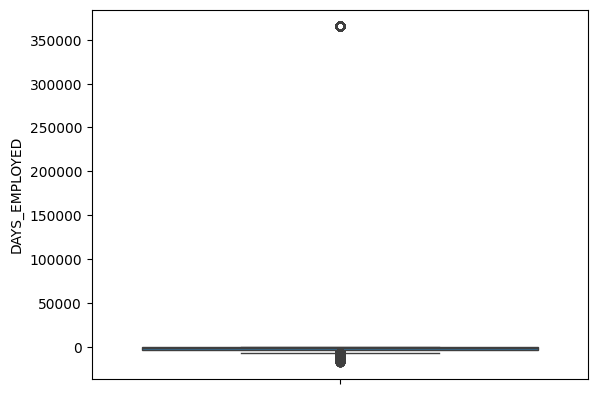

In [19]:
# Distribution of DAYS_EMPLOYED
sns.boxplot(apl['DAYS_EMPLOYED']) # exclude ID

<Axes: ylabel='DAYS_EMPLOYED'>

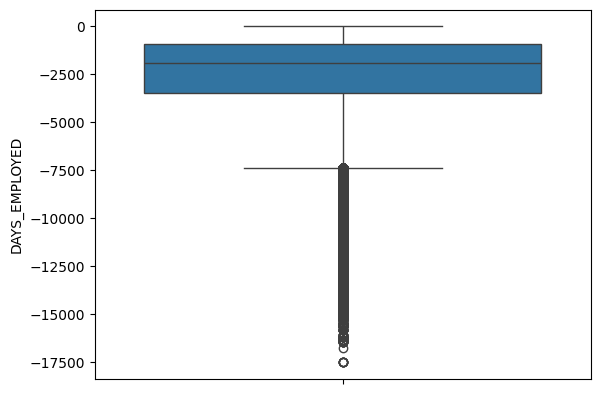

In [20]:
# Distribution of DAYS_EMPLOYED without the outlier
sns.boxplot(apl[apl.DAYS_EMPLOYED != 365243.000000]['DAYS_EMPLOYED'])

Now, let's see the distribution of the whole dataframe.

<Axes: >

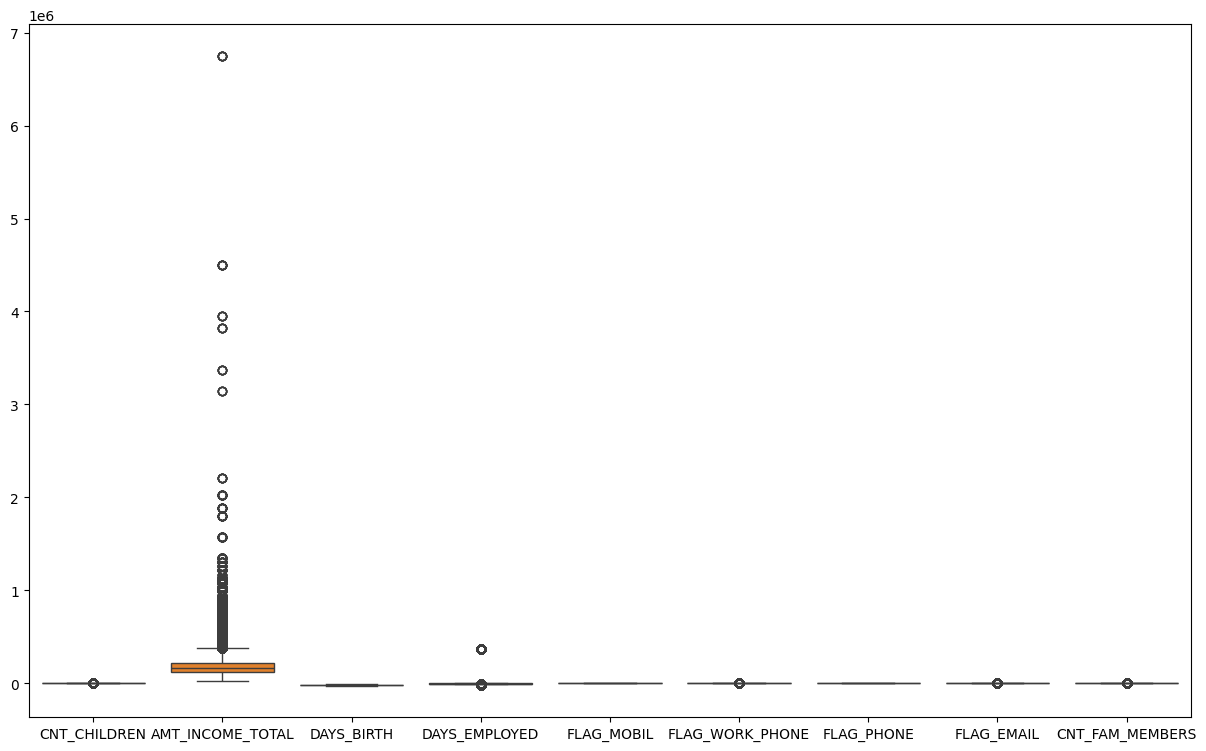

In [21]:
plt.figure(figsize=(15, 9))
sns.boxplot(apl.iloc[:,1:]) # excluding ID

<Axes: >

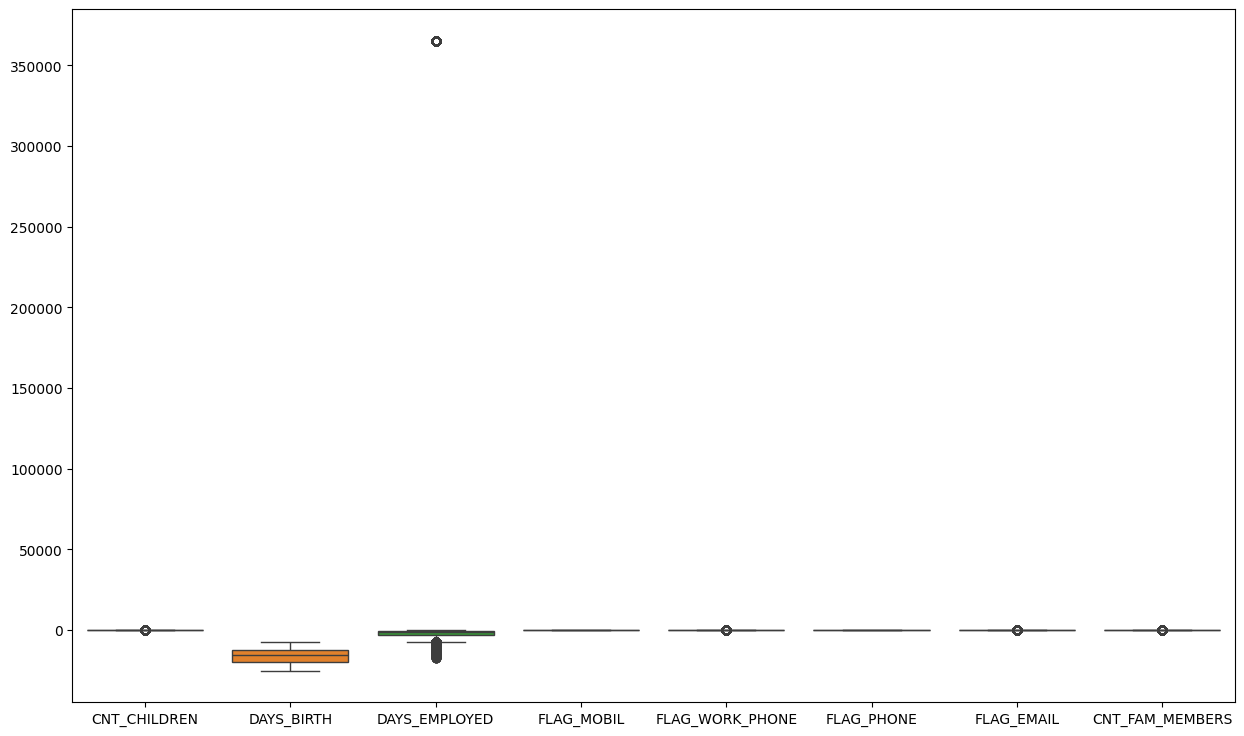

In [22]:
plt.figure(figsize=(15, 9))
sns.boxplot(apl.loc[:, (apl.columns != 'ID') & (apl.columns != 'AMT_INCOME_TOTAL')])

<Axes: ylabel='AMT_INCOME_TOTAL'>

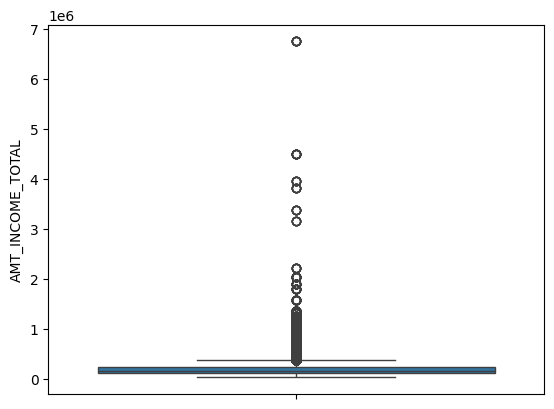

In [23]:
sns.boxplot(apl.loc[:, 'AMT_INCOME_TOTAL'])

<Axes: ylabel='CNT_CHILDREN'>

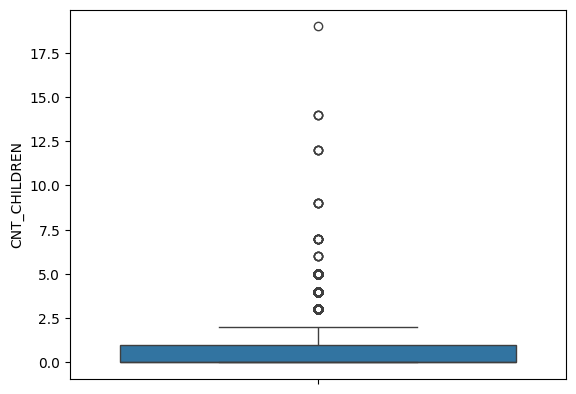

In [24]:
sns.boxplot(data=apl, y=apl['CNT_CHILDREN'])

In [25]:
apl.CNT_CHILDREN.value_counts()

CNT_CHILDREN
0     304071
1      88527
2      39884
3       5430
4        486
5        133
7          9
9          5
12         4
6          4
14         3
19         1
Name: count, dtype: int64

A handful of applicants seem to have a lot of children. It's not very common to have 19 children, so it'll be revised whether these values are made by mistake or not.

Let's see what would the summary statistics look like for people having children (excluding those with 0 children).

In [26]:
apl[apl.CNT_CHILDREN != 0]['CNT_CHILDREN'].describe()

count   134486.00
mean         1.39
std          0.61
min          1.00
25%          1.00
50%          1.00
75%          2.00
max         19.00
Name: CNT_CHILDREN, dtype: float64

The mean and the median indicate 1 children per person in average.

<Axes: ylabel='CNT_CHILDREN'>

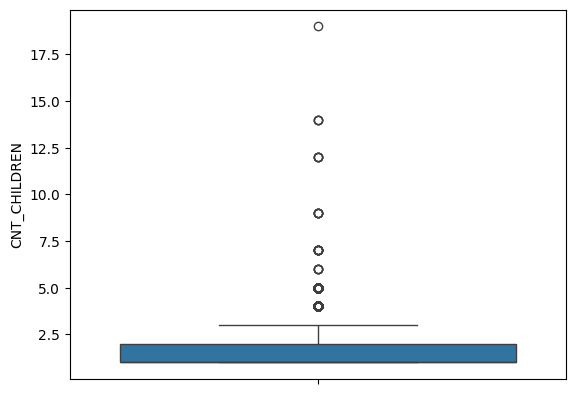

In [27]:
sns.boxplot(data=apl[apl['CNT_CHILDREN'] != 0], y=apl[apl['CNT_CHILDREN'] != 0]['CNT_CHILDREN'])

We still have outliers that need to be dealt with.

<Axes: xlabel='CNT_CHILDREN'>

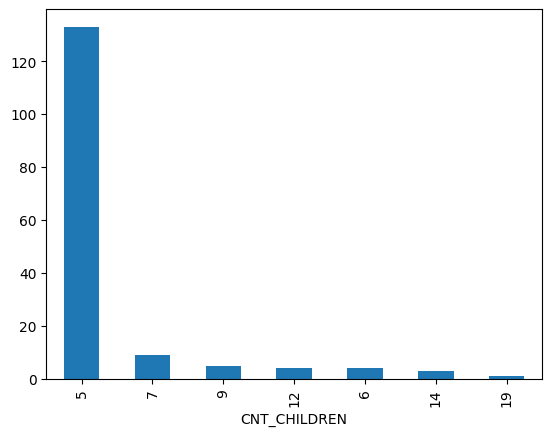

In [28]:
apl.CNT_CHILDREN.value_counts().sort_values(ascending=False)[5:].plot(kind='bar')

### Credit Records

The second dataset consists of past and current credit records of the financial institution's customers. There are 1.048.575 records and 3 columns with information about them.

In [29]:
# Dimensions of the dataset
print("Dimensions of the dataset:", crd.shape)

Dimensions of the dataset: (1048575, 3)


In [30]:
# Peek at the data
crd

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


Apart from the `ID` which is there to help us connect the two dataframes, we have available all of the credit statuses existing clients have had so far that show their financial behaviour every month.

In [31]:
# Data types
print(f"Data types: \n{crd.dtypes}")

Data types: 
ID                 int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object


In [32]:
crd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


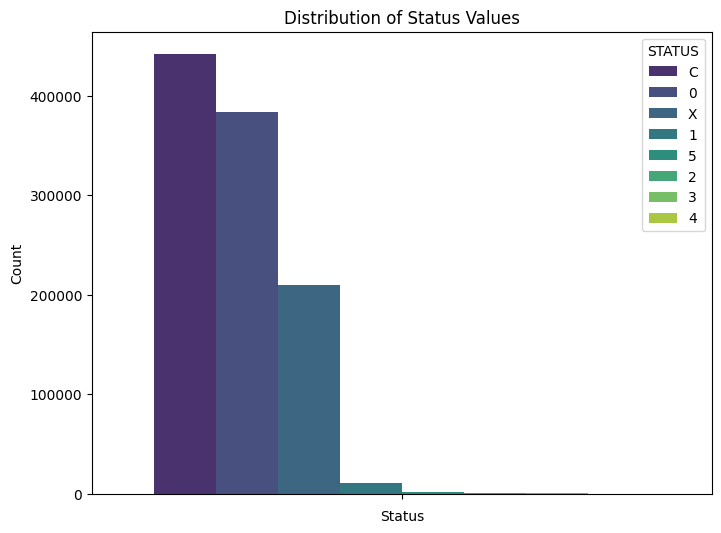

In [33]:
# Assuming merged_data contains the dataset with 'STATUS' column

# Count the occurrences of each status value
status_counts = crd['STATUS'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(hue=status_counts.index, y=status_counts.values, palette="viridis", legend=True)
plt.title("Distribution of Status Values")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()

The imbalance of the data is already visible with most of the values belonging to diligent clients.

The overall dataset will help us build our target variable, the one that will indicate whether a client is risky or not. The strategy needs to combine both the statuses and the months as well. That is because it's important to decline clients that can't keep a healthy open account for a very long time - aka clients who stop paying off their debts (start owing) in a very short time period. Let's take a closer look into our data.

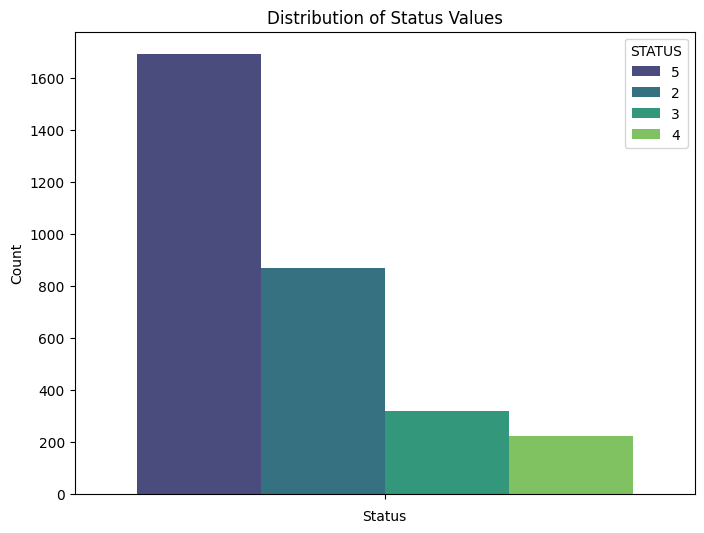

In [34]:
# Assuming merged_data contains the dataset with 'STATUS' column

# Count the occurrences of each status value
status_counts2 = crd[crd.STATUS.isin(['2','3','4','5'])]['STATUS'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(hue=status_counts2.index, y=status_counts2.values, palette="viridis", legend=True)
plt.title("Distribution of Status Values")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()

According to the IFRS 9 a debt goes into default when it's 90 days past due (status 3 in our case), and thus this is going to be one of our thresholds. So, we will consider among other factors a customer being a bad one when they've reached a status 3 or over.

Next, we will attemp whether an applicant might show riky behaviour if we provide them with a credit card.

### Further Analysis on the Credit Records

We start off by creating 3 more columns. We make use of the MONTHS_BALANCE column (that shows the current month each month) to determine the month in which a credit card was given and the month it was cancelled / blocked. Then, using these two new pieces of information, we find the age of the account (how long a credit card has been active).

In [35]:
grouped = crd.groupby('ID')
### convert credit data to wide format which every ID is a row
pivot_tb = crd.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_tb['open_month'] = grouped['MONTHS_BALANCE'].min() # smallest value of MONTHS_BALANCE, is the month when loan was granted
pivot_tb['end_month'] = grouped['MONTHS_BALANCE'].max() # biggest value of MONTHS_BALANCE, might be observe over or canceling account
pivot_tb['ID'] = pivot_tb.index
pivot_tb = pivot_tb[['ID', 'open_month', 'end_month']]
pivot_tb.reset_index(drop = True, inplace = True)

In [36]:
pivot_tb

MONTHS_BALANCE,ID,open_month,end_month
0,5001711,-3,0
1,5001712,-18,0
2,5001713,-21,0
3,5001714,-14,0
4,5001715,-59,0
...,...,...,...
45980,5150482,-28,-11
45981,5150483,-17,0
45982,5150484,-12,0
45983,5150485,-1,0


We then join this table on the original one to bring in information about the clients' "credit scoring" behaviour.

In [37]:
credit = pd.merge(crd, pivot_tb, on = 'ID', how = 'left') # join calculated information
credit

,ID,MONTHS_BALANCE,STATUS,open_month,end_month
0,5001711,0,X,-3,0
1,5001711,-1,0,-3,0
2,5001711,-2,0,-3,0
3,5001711,-3,0,-3,0
4,5001712,0,C,-18,0
...,...,...,...,...,...
1048570,5150487,-25,C,-29,0
1048571,5150487,-26,C,-29,0
1048572,5150487,-27,C,-29,0
1048573,5150487,-28,C,-29,0


In [38]:
# Calculating observe window / the age of the account in months and years respectively
credit['account_age_months'] = abs(credit['open_month'] - credit['MONTHS_BALANCE'])
credit['account_age_years'] = round(abs(credit['open_month'] - credit['MONTHS_BALANCE']) / 12, 1)


In [39]:
credit

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,account_age_months,account_age_years
0,5001711,0,X,-3,0,3,0.20
1,5001711,-1,0,-3,0,2,0.20
2,5001711,-2,0,-3,0,1,0.10
3,5001711,-3,0,-3,0,0,0.00
4,5001712,0,C,-18,0,18,1.50
...,...,...,...,...,...,...,...
1048570,5150487,-25,C,-29,0,4,0.30
1048571,5150487,-26,C,-29,0,3,0.20
1048572,5150487,-27,C,-29,0,2,0.20
1048573,5150487,-28,C,-29,0,1,0.10


In [40]:
credit.STATUS.value_counts(normalize=True).round(3)

STATUS
C   0.42
0   0.36
X   0.20
1   0.01
5   0.00
2   0.00
3   0.00
4   0.00
Name: proportion, dtype: float64

Alongside our previous plot, we can see that the 36% of credit card holders have been late to pay their loan for a month (and about 48% for either a month or about over a month). On the other hand the last statuses (like 4 and 5) have such really small percentages, but we regardless decide to go for status 3 following the IFRS 9 and in order to end up with some sort of "middlepoint" that won't let laons out of control for too long.

Now, we're interested in figuring out the point at which someone manages to get a status 3 (not paying for more than 90 days) for the first time.

In [41]:
# Peek at data of people which a status 3
credit[credit.STATUS == "3"]

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,account_age_months,account_age_years
8912,5002126,-47,3,-55,0,8,0.70
8913,5002126,-48,3,-55,0,7,0.60
34911,5003267,-50,3,-53,0,3,0.20
34912,5003267,-51,3,-53,0,2,0.20
44246,5003712,-23,3,-37,0,14,1.20
...,...,...,...,...,...,...,...
1020098,5148602,-5,3,-15,0,10,0.80
1025698,5148932,-46,3,-54,0,8,0.70
1025743,5148934,-13,3,-21,0,8,0.70
1040956,5149834,-13,3,-23,0,10,0.80


This is an example of a single random customer. They start of by being relatively late to pay their loans and finally reach a status 2 in the 33th month (after almost 3 years).

In [42]:
# credit[credit.ID == 5002255]
credit[credit.ID == 5009524]

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,account_age_months,account_age_years
104474,5009524,0,3,-19,0,19,1.60
104475,5009524,-1,2,-19,0,18,1.50
104476,5009524,-2,1,-19,0,17,1.40
104477,5009524,-3,1,-19,0,16,1.30
104478,5009524,-4,1,-19,0,15,1.20
104479,5009524,-5,1,-19,0,14,1.20
104480,5009524,-6,0,-19,0,13,1.10
104481,5009524,-7,0,-19,0,12,1.00
104482,5009524,-8,1,-19,0,11,0.90
104483,5009524,-9,0,-19,0,10,0.80


Now we will create a new column that will show how many months it took a customer that reached a status 2, to actually reach it for the first time with their loan.

In [43]:
min_month = credit[credit.STATUS == "3"].groupby("ID").min() # first month a client got a status 3
min_month['open_month'] = min_month['open_month'].astype(int)
min_month['MONTHS_BALANCE'] = min_month['MONTHS_BALANCE'].astype(int) 
min_month["first_time_bad"] = abs(min_month["open_month"] - min_month["MONTHS_BALANCE"]) # how many months after opening their account they became a bad customer

In [44]:
min_month['ID'] = min_month.index
min_month = min_month[['ID', 'MONTHS_BALANCE', 'STATUS', 'open_month', 'end_month', 'account_age_months', 'account_age_years', 'first_time_bad']]
min_month.reset_index(drop = True, inplace = True)

In [45]:
min_month.first_time_bad.value_counts(normalize=True).round(2).sort_index(ascending=True)

first_time_bad
2    0.00
3    0.06
4    0.05
5    0.06
6    0.07
7    0.08
8    0.09
9    0.06
10   0.06
11   0.04
12   0.11
13   0.04
14   0.08
15   0.01
16   0.01
17   0.01
18   0.01
19   0.01
20   0.01
21   0.01
22   0.01
24   0.00
25   0.01
26   0.02
28   0.00
29   0.00
30   0.01
31   0.01
33   0.00
35   0.02
36   0.01
38   0.00
40   0.00
Name: proportion, dtype: float64

([<matplotlib.axis.YTick at 0x23365ff8710>,
 [Text(0, 0.0, '0.00'),
  Text(0, 0.01, '0.01'),
  Text(0, 0.02, '0.02'),
  Text(0, 0.03, '0.03'),
  Text(0, 0.04, '0.04'),
  Text(0, 0.05, '0.05'),
  Text(0, 0.06, '0.06'),
  Text(0, 0.07, '0.07'),
  Text(0, 0.08, '0.08'),
  Text(0, 0.09, '0.09'),
  Text(0, 0.1, '0.10'),
  Text(0, 0.11, '0.11'),
  Text(0, 0.12, '0.12')])

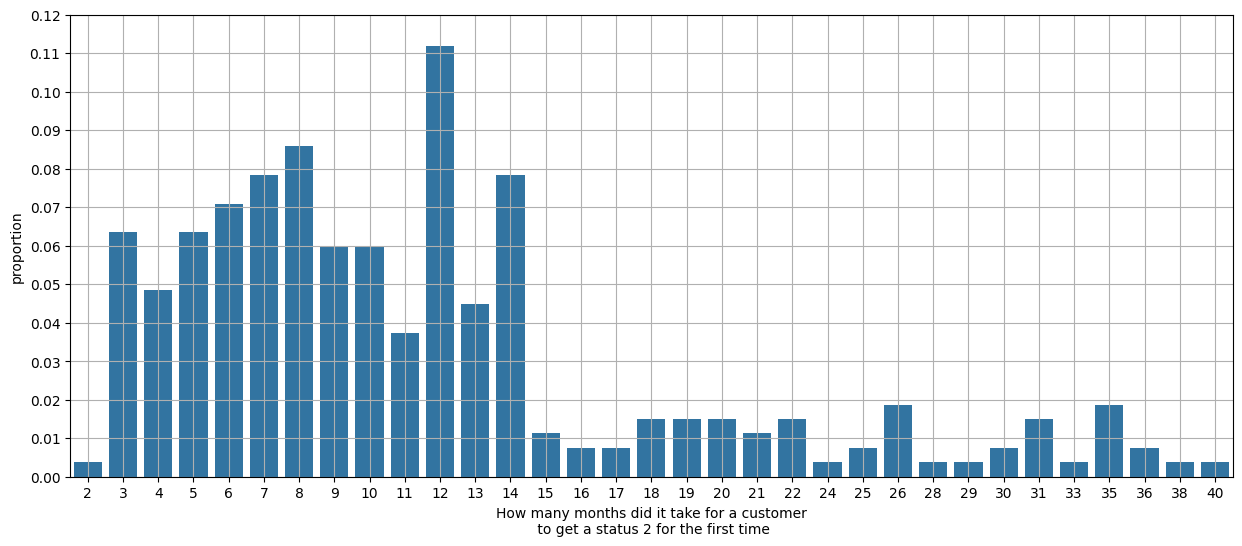

In [46]:
ftbplot = min_month.first_time_bad.value_counts(normalize=True)
plt.figure(figsize=(15, 6))
sns.barplot(ftbplot)
plt.xlabel("How many months did it take for a customer\n to get a status 2 for the first time")
plt.grid(True)
plt.yticks(np.arange(round(min(ftbplot),2), round(max(ftbplot),2)+0.02, 0.01))

We can see that most of credit card holders start owing more than 3 months in the first year of their contract with a peak at the 12th month (meaning they stopped paying in the second quarter atfer getting their credit card). The amount falls significantly at the 15th month and this will be the threshold to help us construct our target variable. It is apparent that the less frequent cases are those that occur after 35 months (less than 1%), but 3~ years is a very wide window to consider. That is why we're restricting debts earlier. At 15 months we're between 1% and 2%.

## Data Preprocessing (features)

In [47]:
apl.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')

In [48]:
# Changing the order of the columns
aplml = apl[['ID', 'CODE_GENDER', 'DAYS_BIRTH', 'NAME_FAMILY_STATUS', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']].copy()

In [49]:
# Changing the columns' names
aplml.columns = ['ID', 'gender', 'days_birth', 'family_status', 'children_count', 'fam_members_count', 'income', 'income_type', 'days_employed', 'occupation_type', 'owns_car', 'owns_property', 'has_mobile', 'has_work_phone', 'has_phone', 'has_email']

In [50]:
aplml

,ID,gender,days_birth,family_status,children_count,fam_members_count,income,income_type,days_employed,occupation_type,owns_car,owns_property,has_mobile,has_work_phone,has_phone,has_email
0,5008804,M,-12005,Civil marriage,0,2.00,427500.00,Working,-4542,NaN,Y,Y,1,1,0,0
1,5008805,M,-12005,Civil marriage,0,2.00,427500.00,Working,-4542,NaN,Y,Y,1,1,0,0
2,5008806,M,-21474,Married,0,2.00,112500.00,Working,-1134,Security staff,Y,Y,1,0,0,0
3,5008808,F,-19110,Single / not married,0,1.00,270000.00,Commercial associate,-3051,Sales staff,N,Y,1,0,1,1
4,5008809,F,-19110,Single / not married,0,1.00,270000.00,Commercial associate,-3051,Sales staff,N,Y,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,-22717,Separated,0,1.00,135000.00,Pensioner,365243,NaN,N,Y,1,0,0,0
438553,6840222,F,-15939,Single / not married,0,1.00,103500.00,Working,-3007,Laborers,N,N,1,0,0,0
438554,6841878,F,-8169,Single / not married,0,1.00,54000.00,Commercial associate,-372,Sales staff,N,N,1,1,0,0
438555,6842765,F,-21673,Married,0,2.00,72000.00,Pensioner,365243,NaN,N,Y,1,0,0,0


In [51]:
# Fill in the missing values we know the values for
aplml.loc[aplml['income_type'] == "Pensioner", "occupation_type"] = "Pensioners"
aplml.occupation_type.value_counts(dropna=False)

occupation_type
Laborers                 78209
Pensioners               75493
NaN                      58846
Core staff               42974
Sales staff              41089
Managers                 35468
Drivers                  26079
High skill tech staff    17281
Accountants              15980
Medicine staff           13510
Cooking staff             8071
Security staff            7991
Cleaning staff            5845
Private service staff     3456
Low-skill Laborers        2139
Secretaries               2042
Waiters/barmen staff      1665
Realty agents             1041
HR staff                   774
IT staff                   604
Name: count, dtype: int64

In [52]:
# Missing values - fill in the rest
aplml['occupation_type'].fillna('Not specified',inplace=True)
aplml['occupation_type'].value_counts(dropna=False)

occupation_type
Laborers                 78209
Pensioners               75493
Not specified            58846
Core staff               42974
Sales staff              41089
Managers                 35468
Drivers                  26079
High skill tech staff    17281
Accountants              15980
Medicine staff           13510
Cooking staff             8071
Security staff            7991
Cleaning staff            5845
Private service staff     3456
Low-skill Laborers        2139
Secretaries               2042
Waiters/barmen staff      1665
Realty agents             1041
HR staff                   774
IT staff                   604
Name: count, dtype: int64

In [53]:
aplml.columns

Index(['ID', 'gender', 'days_birth', 'family_status', 'children_count',
       'fam_members_count', 'income', 'income_type', 'days_employed',
       'occupation_type', 'owns_car', 'owns_property', 'has_mobile',
       'has_work_phone', 'has_phone', 'has_email'],
      dtype='object')

In [54]:
# Handling age
aplml['days_birth'] = round(-aplml['days_birth'] / 365.2425, 0).astype(int)

In [55]:
aplml.rename(columns={'days_birth': 'age'}, inplace=True)

In [56]:
aplml

,ID,gender,age,family_status,children_count,fam_members_count,income,income_type,days_employed,occupation_type,owns_car,owns_property,has_mobile,has_work_phone,has_phone,has_email
0,5008804,M,33,Civil marriage,0,2.00,427500.00,Working,-4542,Not specified,Y,Y,1,1,0,0
1,5008805,M,33,Civil marriage,0,2.00,427500.00,Working,-4542,Not specified,Y,Y,1,1,0,0
2,5008806,M,59,Married,0,2.00,112500.00,Working,-1134,Security staff,Y,Y,1,0,0,0
3,5008808,F,52,Single / not married,0,1.00,270000.00,Commercial associate,-3051,Sales staff,N,Y,1,0,1,1
4,5008809,F,52,Single / not married,0,1.00,270000.00,Commercial associate,-3051,Sales staff,N,Y,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,62,Separated,0,1.00,135000.00,Pensioner,365243,Pensioners,N,Y,1,0,0,0
438553,6840222,F,44,Single / not married,0,1.00,103500.00,Working,-3007,Laborers,N,N,1,0,0,0
438554,6841878,F,22,Single / not married,0,1.00,54000.00,Commercial associate,-372,Sales staff,N,N,1,1,0,0
438555,6842765,F,59,Married,0,2.00,72000.00,Pensioner,365243,Pensioners,N,Y,1,0,0,0


In [57]:
# Deal with the positive outlier in the days_employed
aplml.loc[aplml['days_employed'] == 365243, 'days_employed'] = aplml[aplml["days_employed"] != 365243]["days_employed"].min() # changed value to the minimum value (remember the values are negative)

In [58]:
# Create years employed feature
aplml['days_employed'] = round(-aplml['days_employed'] / 365.2425).astype(int)

In [59]:
aplml.rename(columns={'days_employed': 'years_employed'}, inplace=True)

In [60]:
aplml.years_employed.describe()[1:]

mean   14.20
std    16.52
min     0.00
25%     3.00
50%     7.00
75%    16.00
max    48.00
Name: years_employed, dtype: float64

Notice how the maximum value is 48 years (minimum negative). If we add 18 (supposing that a person starts working then they're 18 years old in Greece) then we get 66 years. Almost 1 year far from retirement. We didn't eliminate Pensioner's employment time, as they have a monthly and steady income, unlike other candidates that might be unemployed or employed for a very short time period.

## Credit Records

In [61]:
credit

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,account_age_months,account_age_years
0,5001711,0,X,-3,0,3,0.20
1,5001711,-1,0,-3,0,2,0.20
2,5001711,-2,0,-3,0,1,0.10
3,5001711,-3,0,-3,0,0,0.00
4,5001712,0,C,-18,0,18,1.50
...,...,...,...,...,...,...,...
1048570,5150487,-25,C,-29,0,4,0.30
1048571,5150487,-26,C,-29,0,3,0.20
1048572,5150487,-27,C,-29,0,2,0.20
1048573,5150487,-28,C,-29,0,1,0.10


We create a new column "bad" that will represent the monthly score for each status. The mapping includes a neutral score of 0 for people with no loans, an increasing positive score for people not paying off their loans and a negative -3.5 (average of positive scores) score for payments.

In [62]:
credit['bad'] = credit['STATUS'].copy()
credit['bad'].replace({'X': 0, 'C': -3.5, '0': 1, '1':2, '2':3, '3':4, '4':5, '5':6}, inplace=True)

In [63]:
credit

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,account_age_months,account_age_years,bad
0,5001711,0,X,-3,0,3,0.20,0.00
1,5001711,-1,0,-3,0,2,0.20,1.00
2,5001711,-2,0,-3,0,1,0.10,1.00
3,5001711,-3,0,-3,0,0,0.00,1.00
4,5001712,0,C,-18,0,18,1.50,-3.50
...,...,...,...,...,...,...,...,...
1048570,5150487,-25,C,-29,0,4,0.30,-3.50
1048571,5150487,-26,C,-29,0,3,0.20,-3.50
1048572,5150487,-27,C,-29,0,2,0.20,-3.50
1048573,5150487,-28,C,-29,0,1,0.10,-3.50


Since our main focus is people reaching status 3 in less than 15 months, we construct a new column "risky" that will declare risky people who reach a status 3 in less than 15 months.

In [64]:
credit["risky"] = 0
for i in range(len(credit)):
    if credit.loc[i, "STATUS"] == "3" and credit.loc[i, "account_age_months"] < 15:
        credit.loc[i, "risky"] = 1
    else:
        continue

In [65]:
credit.risky.value_counts()

risky
0    1048329
1        246
Name: count, dtype: int64

In [66]:
credit

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,account_age_months,account_age_years,bad,risky
0,5001711,0,X,-3,0,3,0.20,0.00,0
1,5001711,-1,0,-3,0,2,0.20,1.00,0
2,5001711,-2,0,-3,0,1,0.10,1.00,0
3,5001711,-3,0,-3,0,0,0.00,1.00,0
4,5001712,0,C,-18,0,18,1.50,-3.50,0
...,...,...,...,...,...,...,...,...,...
1048570,5150487,-25,C,-29,0,4,0.30,-3.50,0
1048571,5150487,-26,C,-29,0,3,0.20,-3.50,0
1048572,5150487,-27,C,-29,0,2,0.20,-3.50,0
1048573,5150487,-28,C,-29,0,1,0.10,-3.50,0


In [67]:
credit[credit.risky == 1]

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,account_age_months,account_age_years,bad,risky
8912,5002126,-47,3,-55,0,8,0.70,4.00,1
8913,5002126,-48,3,-55,0,7,0.60,4.00,1
34911,5003267,-50,3,-53,0,3,0.20,4.00,1
34912,5003267,-51,3,-53,0,2,0.20,4.00,1
44246,5003712,-23,3,-37,0,14,1.20,4.00,1
...,...,...,...,...,...,...,...,...,...
1020098,5148602,-5,3,-15,0,10,0.80,4.00,1
1025698,5148932,-46,3,-54,0,8,0.70,4.00,1
1025743,5148934,-13,3,-21,0,8,0.70,4.00,1
1040956,5149834,-13,3,-23,0,10,0.80,4.00,1


Now, focusing on our newly created columns ("bad" and "risky") we will compute the summation of bad score per ID to see if there are any customers identified as risky (having reached a status of 3 in less than 15 months) that otherwise show a positive / responsible attitude overall. If someone reaches a status of 3 but in the majority of the times they are diligent with their payments, it's fair to declare them as safe candidates.

In [68]:
ids = credit.groupby(['ID', 'risky'])[['bad']].agg("sum").reset_index()

In [69]:
ids[(ids.risky == 1) & (ids.bad <= 0)]

,ID,risky,bad


Based on this very brief analysis, there are no risky customers with a non-positive score, therefore we can simply proceed with "risky" as our target variable.

To make things a bit more clear:

- High risk customer (risky=1) = Credit card application declined
- Low risk customer (risky=0) = Credit card application approved

Now that we have defined risky clients, we are able to train a model on application data (like income amount or property ownership) of customers that have already been labelled as risky or not risky to predict the financial behaviour of new customers that are not yet in our records.

## Final Table

Between 0 and 1, choose the highest (1) risky label per customer, in case someone shows both risky and non-risky behaviour (we would like to end up with a final label that will apply to the customer's profile and not their individual monthly behaviour).

In [70]:
final_t = credit.groupby(['ID'])['risky'].agg("max").reset_index() 

The counts feel reasonably lower (this is again due to the aggregation), and the ratio of the risky customers is low compared to the non-risky ones.

In [71]:
final_t["risky"].value_counts()

risky
0    45769
1      216
Name: count, dtype: int64

In [72]:
final_t["risky"].value_counts(normalize=True)

risky
0   1.00
1   0.00
Name: proportion, dtype: float64

Now that our target variable is ready, we will continue with feature engineering before wrapping up everything together in a way that makes sense.

## Feature Engineering

In [73]:
aplml

,ID,gender,age,family_status,children_count,fam_members_count,income,income_type,years_employed,occupation_type,owns_car,owns_property,has_mobile,has_work_phone,has_phone,has_email
0,5008804,M,33,Civil marriage,0,2.00,427500.00,Working,12,Not specified,Y,Y,1,1,0,0
1,5008805,M,33,Civil marriage,0,2.00,427500.00,Working,12,Not specified,Y,Y,1,1,0,0
2,5008806,M,59,Married,0,2.00,112500.00,Working,3,Security staff,Y,Y,1,0,0,0
3,5008808,F,52,Single / not married,0,1.00,270000.00,Commercial associate,8,Sales staff,N,Y,1,0,1,1
4,5008809,F,52,Single / not married,0,1.00,270000.00,Commercial associate,8,Sales staff,N,Y,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,62,Separated,0,1.00,135000.00,Pensioner,48,Pensioners,N,Y,1,0,0,0
438553,6840222,F,44,Single / not married,0,1.00,103500.00,Working,8,Laborers,N,N,1,0,0,0
438554,6841878,F,22,Single / not married,0,1.00,54000.00,Commercial associate,1,Sales staff,N,N,1,1,0,0
438555,6842765,F,59,Married,0,2.00,72000.00,Pensioner,48,Pensioners,N,Y,1,0,0,0


Before diving into scaling and encoding, handling some skewed data is necessary. Specifically, we saw that there are some extremely rare values in "children_count" (someone had 19 children in total) and that there are different income amounts indicating different income categories and not necessarily data entry errors.

Firstly, we need to answer this question: What is an outlier?

Well, outliers need to be defined using the data's distribution (think of the boxplots we saw earlier). If data is allowed to lie far from the more central area towards the ends of the whiskers, then we need to define how far the data needs to be to be considered something that needs to be fixed. For that, we will use the quantiles and specifically set bounds that are 3 times away from the IQR of the data (of people having children). We chose 3 instead of 1.5 which is more standard so as not to be too strict. We also don't use a lower bound as it's impossible to have a negative amount of children (and we also didn't see any negative values in EDA).

Note that our imputation process envolves the median and not the average mean, as it is more robust against outliers and it provides us with a strictly discrete value.

In [74]:
# Handling outliers

# Sort the DataFrame
aplml = aplml.sort_values(by='children_count')

# Calculate the IQR
Q1 = aplml[aplml.children_count != 0 ]['children_count'].quantile(0.25)
Q3 = aplml[aplml.children_count != 0 ]['children_count'].quantile(0.75)
IQR = Q3 - Q1 # Constructing the IQR range

# # Replace outliers with the median (using bounds the data is not allowed to cross)
aplml.loc[aplml.children_count > Q3 + 3 * IQR, 'children_count'] = int(aplml[aplml.children_count != 0]['children_count'].median())


In [75]:
aplml.children_count.value_counts()

children_count
0    304071
1     88553
2     39884
3      5430
4       486
5       133
Name: count, dtype: int64

<Axes: ylabel='children_count'>

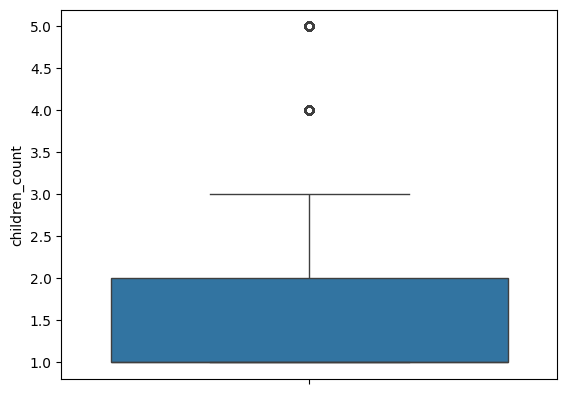

In [76]:
sns.boxplot(data=aplml[aplml['children_count'] != 0], y=aplml[aplml['children_count'] != 0]['children_count'])

Moving forward we change the high-variance income variable to a categorical one through binning (discretization).

In [77]:
# Dealing with the income variable
aplml.income.describe()

count    438557.00
mean     187524.29
std      110086.85
min       26100.00
25%      121500.00
50%      160780.50
75%      225000.00
max     6750000.00
Name: income, dtype: float64

We cut the feature using the quantiles and labelling them in order as "Very Low", "Low", "High" and "Very High".

In [78]:
pd.qcut(aplml.income, q=[0, .25, .5, .75, 1])

0         (225000.0, 6750000.0]
265615     (121500.0, 160780.5]
265614    (26099.999, 121500.0]
265613    (26099.999, 121500.0]
265612    (26099.999, 121500.0]
                  ...          
208909    (225000.0, 6750000.0]
20441      (160780.5, 225000.0]
20442      (160780.5, 225000.0]
20443      (160780.5, 225000.0]
36388     (26099.999, 121500.0]
Name: income, Length: 438557, dtype: category
Categories (4, interval[float64, right]): [(26099.999, 121500.0] < (121500.0, 160780.5] < (160780.5, 225000.0] < (225000.0, 6750000.0]]

In [79]:
pd.qcut(aplml.income, q=[0, .25, .5, .75, 1], labels=['Very Low', 'Low', 'High', 'Very High'])

0         Very High
265615          Low
265614     Very Low
265613     Very Low
265612     Very Low
            ...    
208909    Very High
20441          High
20442          High
20443          High
36388      Very Low
Name: income, Length: 438557, dtype: category
Categories (4, object): ['Very Low' < 'Low' < 'High' < 'Very High']

In [80]:
aplml['income'] = pd.qcut(aplml['income'], q=[0, .25, .5, .75, 1], labels=['Very Low', 'Low', 'High', 'Very High'])

In [81]:
aplml

,ID,gender,age,family_status,children_count,fam_members_count,income,income_type,years_employed,occupation_type,owns_car,owns_property,has_mobile,has_work_phone,has_phone,has_email
0,5008804,M,33,Civil marriage,0,2.00,Very High,Working,12,Not specified,Y,Y,1,1,0,0
265615,6077903,F,54,Married,0,2.00,Low,Pensioner,48,Pensioners,Y,Y,1,0,0,1
265614,6631054,F,53,Married,0,2.00,Very Low,Working,12,Sales staff,Y,Y,1,0,1,0
265613,6077902,F,53,Married,0,2.00,Very Low,Working,12,Sales staff,Y,Y,1,0,1,0
265612,6077901,F,53,Married,0,2.00,Very Low,Working,12,Sales staff,Y,Y,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208909,5931568,F,39,Married,1,14.00,Very High,Commercial associate,7,Core staff,N,Y,1,0,0,0
20441,5061207,M,49,Separated,1,15.00,High,Working,5,Drivers,Y,Y,1,0,0,0
20442,5061210,M,49,Separated,1,15.00,High,Working,5,Drivers,Y,Y,1,0,0,0
20443,5061211,M,49,Separated,1,15.00,High,Working,5,Drivers,Y,Y,1,0,0,0


<Axes: xlabel='income'>

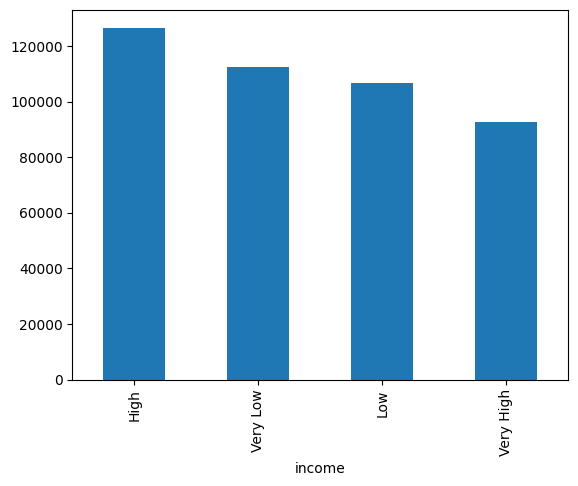

In [82]:
aplml.income.value_counts().sort_values(ascending=False).plot(kind='bar')

In [83]:
aplml

,ID,gender,age,family_status,children_count,fam_members_count,income,income_type,years_employed,occupation_type,owns_car,owns_property,has_mobile,has_work_phone,has_phone,has_email
0,5008804,M,33,Civil marriage,0,2.00,Very High,Working,12,Not specified,Y,Y,1,1,0,0
265615,6077903,F,54,Married,0,2.00,Low,Pensioner,48,Pensioners,Y,Y,1,0,0,1
265614,6631054,F,53,Married,0,2.00,Very Low,Working,12,Sales staff,Y,Y,1,0,1,0
265613,6077902,F,53,Married,0,2.00,Very Low,Working,12,Sales staff,Y,Y,1,0,1,0
265612,6077901,F,53,Married,0,2.00,Very Low,Working,12,Sales staff,Y,Y,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208909,5931568,F,39,Married,1,14.00,Very High,Commercial associate,7,Core staff,N,Y,1,0,0,0
20441,5061207,M,49,Separated,1,15.00,High,Working,5,Drivers,Y,Y,1,0,0,0
20442,5061210,M,49,Separated,1,15.00,High,Working,5,Drivers,Y,Y,1,0,0,0
20443,5061211,M,49,Separated,1,15.00,High,Working,5,Drivers,Y,Y,1,0,0,0


We employ One-hot encoding to deal with the categorical variables 'gender', 'family_status', 'income', 'income_type', 'occupation_type', 'owns_car', 'owns_property', in order to transform them into a binary matrix representation to ensure compatibility with algorithms that require numerical input such as k-nearest neighbors (KNN) algorithm.

In [84]:
# One-hot-encoding of qualitative data (categorical variables where the order is not important)
feature_list = ['gender', 'family_status', 'income', 'income_type', 'occupation_type', 'owns_car', 'owns_property']
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=int)

# Fit and transform the selected features
encoded_features = encoder.fit_transform(aplml[feature_list])

# Create a DataFrame with the one-hot encoded features
aplml_encoded = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(feature_list))

# Concatenate the original DataFrame with the one-hot encoded features
aplml_encoded = pd.concat([aplml, aplml_encoded], axis=1)

# Drop the original categorical columns if needed
aplml_encoded = aplml_encoded.drop(feature_list, axis=1)

In [85]:
final_df = pd.merge(aplml_encoded, final_t, how='left', on=['ID']) # inner join and at the end we predict the NaN targets from the left join

In [86]:
final_df

,ID,age,children_count,fam_members_count,years_employed,has_mobile,has_work_phone,has_phone,has_email,gender_F,...,occupation_type_Realty agents,occupation_type_Sales staff,occupation_type_Secretaries,occupation_type_Security staff,occupation_type_Waiters/barmen staff,owns_car_N,owns_car_Y,owns_property_N,owns_property_Y,risky
0,5008804,33,0,2.00,12,1,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0.00
1,6077903,54,0,2.00,48,1,0,0,1,0,...,0,0,0,0,0,0,1,0,1,NaN
2,6631054,53,0,2.00,12,1,0,1,0,0,...,0,0,0,0,0,0,1,0,1,NaN
3,6077902,53,0,2.00,12,1,0,1,0,1,...,0,0,0,0,0,1,0,0,1,NaN
4,6077901,53,0,2.00,12,1,0,1,0,1,...,0,0,0,0,0,1,0,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,5931568,39,1,14.00,7,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,NaN
438553,5061207,49,1,15.00,5,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0.00
438554,5061210,49,1,15.00,5,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0.00
438555,5061211,49,1,15.00,5,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0.00


We drop columns that don't seem helpful considering the domain

In [87]:
# Drop columns that don't seem helpful
print("Before drop:", aplml.shape)
aplml.drop(columns=['has_mobile', 'has_work_phone', 'has_phone', 'has_email'], inplace=True)
print("After drop:", aplml.shape)

Before drop: (438557, 16)
After drop: (438557, 12)


 Split the data in the training set that is already labelled and the set that needs to be predicted as the main goal. The labelled set will be used for the training of the model.

In [88]:
# Split the data in the training set that is already labelled and the set that needs to be predicted as the main goal.
train_df = final_df[~final_df.risky.isnull()]
pred_df = final_df[final_df.risky.isnull()]

Split the labelled data in features and target variables

In [89]:
# Split the data in features and target variables
X = train_df.loc[:, ~train_df.columns.isin(['ID', 'risky'])] # features
Y = train_df[['risky']] # target

We  employ StandardScaler to standardize the numerical features 'children_count', 'age', 'years_employed', 'fam_members_count', ensuring they share a consistent scale. This is imperative for algorithms sensitive to feature scaling such as k-nearest neighbors (KNN) algorithm.

Then, we select 10 best features using SelectKBest to reduce the dimensionality of the data set.

In [91]:
# Split the data in features and target variables
# Standardization of quantitative data
fdf = train_df.copy()
columns_to_scale = ['children_count', 'age', 'years_employed', 'fam_members_count']
st=StandardScaler()
fdf[columns_to_scale] = st.fit_transform(fdf[columns_to_scale])

X = fdf.loc[:, ~fdf.columns.isin(['ID', 'risky'])] # features
Y = fdf[['risky']] # target

selector = SelectKBest(f_classif, k=10) 
selector.fit(X, Y) 

print('\nInput features scores :', selector.scores_) 
print('\nInput features pvalues:', selector.pvalues_) 
print('\nOutput features Names :', selector.get_feature_names_out())


Input features scores : [1.00472103e+01 2.74339628e+00 8.49902701e+00 5.41044085e+00
            nan 5.49073631e-01 5.22916935e-01 3.63837078e-02
 3.61741116e-01 3.61741116e-01 1.01478886e+00 1.02777626e+01
 6.17907903e-01 7.74974941e+00 3.55768406e+00 3.37641413e+00
 2.24619254e+00 1.45174906e+00 2.27776207e+00 1.16841008e-01
 2.14869035e+01 6.44715772e-01            nan 1.46599511e+01
 2.08294045e+00 3.50630774e-01 2.04926607e+01 6.84491320e+00
 3.73694941e-01 4.26830457e-01 4.22305474e-01 1.85828314e-01
 3.57943706e-01 1.35787356e-03 5.87121569e+00 7.81972211e-01
 2.85702473e-01 2.14869035e+01 5.73985019e+00 3.17211403e-01
 4.62675806e+00 8.83047571e-01 2.03301164e+00 1.29090389e-01
 3.86672589e+00 3.86672589e+00 7.74653204e+00 7.74653204e+00]

Input features pvalues: [1.52704944e-03 9.76656177e-02 3.55552724e-03 2.00221152e-02
            nan 4.58701228e-01 4.69604686e-01 8.48726335e-01
 5.47544591e-01 5.47544591e-01 3.13764990e-01 1.34759165e-03
 4.31830896e-01 5.37476628e-03 5.9

In [92]:
fdf_best = fdf.loc[:,selector.get_feature_names_out()]
fdf_best

,age,fam_members_count,family_status_Married,family_status_Single / not married,income_type_Pensioner,income_type_Working,occupation_type_Cooking staff,occupation_type_Pensioners,owns_property_N,owns_property_Y
0,-0.93,-0.22,0,0,0,1,0,0,0,1
118660,1.32,-0.22,1,0,0,0,0,0,0,1
118661,-1.63,-0.22,1,0,0,0,0,0,0,1
118662,-1.63,-0.22,1,0,0,0,0,0,0,1
118663,-1.63,-0.22,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
438539,-0.50,7.46,1,0,0,0,0,0,0,1
438553,0.46,14.04,0,0,0,1,0,0,0,1
438554,0.46,14.04,0,0,1,0,0,1,0,1
438555,0.46,14.04,0,0,1,0,0,1,0,1


## Algorithm Selection

We split the X- features Table and Y-Target into training and test set.

In [93]:
X_train, X_test, y_train, y_test = train_test_split(fdf_best, Y, test_size=0.2, stratify=Y, random_state=0)

In [94]:
Y.value_counts()

risky
0.00     36259
1.00       198
Name: count, dtype: int64

In [95]:
y_train.value_counts()

risky
0.00     29007
1.00       158
Name: count, dtype: int64

In [96]:
y_test.value_counts()

risky
0.00     7252
1.00       40
Name: count, dtype: int64

Above, we observe that the target column 'risky' exhibits imbalanced data; 'non-risky' clients significantly outnumber 'risky' ones in both the training and test sets. This is a challenge we will need to address later.

We select both basic models and ensemble models to train our data.

In [97]:
# Classifiers to train 
classifiers1 = [
        ('Decision Tree', DecisionTreeClassifier()),
        ('Naive Bayes', GaussianNB()),
        ('Logistic Regression', LogisticRegression()),
        ('kNN', KNeighborsClassifier())
        ]

In [99]:
classifiers2 = [
        ('Decision Tree', DecisionTreeClassifier()),
        ('Adaboost', AdaBoostClassifier()),
        ('XGBoost', xgb.XGBClassifier()),
        ('Gradient Boost', GradientBoostingClassifier()),
        ('Random Forest', RandomForestClassifier())
]

We employ cross-validation to offer a more comprehensive evaluation of the model's generalization capabilities. Additionally, we define the metrics that will be used to assess the basic classifiers.

In [113]:
# With 10 key features, without dealing with the data imbalance
# selector = SelectKBest(f_classif, k=10) 
# selector.fit(X_train, y_train) 

# fdf_best = fdf.loc[:,selector.get_feature_names_out()]

for name, classifier in classifiers1:
        accuracy = cross_val_score(classifier, X_train, y_train, cv=KFold(10), scoring='accuracy')
        recall = cross_val_score(classifier, X_train, y_train, cv=KFold(10), scoring='recall')
        precision = cross_val_score(classifier, X_train, y_train, cv=KFold(10), scoring='precision')
        f1 = cross_val_score(classifier, X_train, y_train, cv=KFold(10), scoring='f1')
        print(f"{name} | Mean accuracy: {np.mean(accuracy)} ({np.std(accuracy)})")
        print(f"{name} | Mean recall: {np.mean(recall)} ({np.std(recall)})")
        print(f"{name} | Mean precision: {np.mean(precision)} ({np.std(precision)})")
        print(f"{name} | Mean F1: {np.mean(f1)} ({np.std(f1)})")
        print(f"{name} | Confusion Matrix: {confusion_matrix(y_test, classifier.predict(X_test))}\n")


Decision Tree | Mean accuracy: 0.9941369075750544 (0.0021323386002913215)
Decision Tree | Mean recall: 0.020833333333333332 (0.042695628191498324)
Decision Tree | Mean precision: 0.08333333333333333 (0.20069324297987154)
Decision Tree | Mean F1: 0.03216374269005848 (0.06806022716235377)

Decision Tree | Confusion Matrix:
 [[7034  218]
 [  36    4]]
Naive Bayes | Mean accuracy: 0.9815875834061056 (0.003546464988841119)
Naive Bayes | Mean recall: 0.04744725375530329 (0.05944806076091101)
Naive Bayes | Mean precision: 0.018690680388793596 (0.02168621582875024)
Naive Bayes | Mean F1: 0.02661095848595848 (0.031474026599176454)

Naive Bayes | Confusion Matrix:
 [[2867 4385]
 [   7   33]]
Logistic Regression | Mean accuracy: 0.9945826414664897 (0.0021993433813666955)
Logistic Regression | Mean recall: 0.0 (0.0)
Logistic Regression | Mean precision: 0.0 (0.0)
Logistic Regression | Mean F1: 0.0 (0.0)

Logistic Regression | Confusion Matrix:
 [[3949 3303]
 [  12   28]]
kNN | Mean accuracy: 0.994

Above, we observe that while the models perform well in terms of accuracy, there are notable issues with precision and recall. For instance, Logistic Regression exhibits a recall of 0 for both classes.

Thus, we attempt to address the class imbalance issue using SMOTE (Synthetic Minority Over-sampling Technique) in combination with stratified 10-Fold Cross-Validation.

In [103]:
# With 10 features and Dealing with class imbalance with SMOTE and STRATIFIED 10-Fold CV
from imblearn.combine import SMOTEENN
names = []
results = []
start_time = timeit.default_timer()

for name, classifier in classifiers1:
    sme = SMOTEENN(random_state=42)
    accuracy = []
    recall = []
    precision = []
    f1 = []

    for train_index, test_index in StratifiedKFold(n_splits=10, shuffle=True).split(X_train, y_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # Apply SMOTE to the training data
        X_train_smote, y_train_smote = sme.fit_resample(X_train_cv, y_train_cv)
        
        start_train_time = time.time()
        classifier.fit(X_train_smote, y_train_smote)
        end_train_time = time.time()
        train_time = end_train_time - start_train_time
        print(f"{name} | Confusion Matrix:\n {confusion_matrix(y_test_cv, classifier.predict(X_test_cv))}")

        accuracy.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='accuracy'))
        recall.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='recall'))
        precision.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='precision'))
        f1.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='f1'))

    names.append(name)
    results.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='recall'))
    print(f"{name} | Training time: {train_time:.2f} seconds\n")

    print(f"{name} | Accuracy scores: {accuracy}")
    print(f"{name} | Mean accuracy: {np.mean(accuracy)} ({np.std(accuracy)})\n")
    print(f"{name} | Recall scores: {recall}")
    print(f"{name} | Mean recall: {np.mean(recall)} ({np.std(recall)})\n")
    print(f"{name} | Precision scores: {precision}")
    print(f"{name} | Mean precision: {np.mean(precision)} ({np.std(precision)})\n")
    print(f"{name} | F1 scores: {f1}")
    print(f"{name} | Mean F1: {np.mean(f1)} ({np.std(f1)})")
    print("=================================================\n")

# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison (recall score)')
plt.xticks(rotation=90)
plt.show()

Decision Tree | Confusion Matrix:
 [[2859   42]
 [  14    2]]
Decision Tree | Confusion Matrix:
 [[2866   35]
 [  14    2]]
Decision Tree | Confusion Matrix:
 [[2840   61]
 [  16    0]]
Decision Tree | Confusion Matrix:
 [[2848   53]
 [  15    1]]


KeyboardInterrupt: 

We can observe that our results are not satisfactory either.

Now, we attempt to address the class imbalance issue using ADASYN in combination with stratified 10-Fold Cross-Validation.

In [110]:
# With 10 features and Dealing with class imbalance with ADASYN and STRATIFIED 10-Fold CV
from imblearn.over_sampling import ADASYN
names = []
results = []
start_time = timeit.default_timer()

for name, classifier in classifiers1:
    ada = ADASYN(random_state=42)
    accuracy = []
    recall = []
    precision = []
    f1 = []

    for train_index, test_index in StratifiedKFold(n_splits=10, shuffle=True).split(X_train, y_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # Apply SMOTE to the training data
        X_train_ada, y_train_ada = ada.fit_resample(X_train_cv, y_train_cv)
        start_train_time = time.time()
        classifier.fit(X_train_ada, y_train_ada)
        end_train_time = time.time()
        train_time = end_train_time - start_train_time
        print(f"{name} | Confusion Matrix:\n {confusion_matrix(y_test_cv, classifier.predict(X_test_cv))}")

        accuracy.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='accuracy'))
        recall.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='recall'))
        precision.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='precision'))
        f1.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='f1'))

    names.append(name)
    results.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='recall'))
    print(f"{name} | Training time: {train_time:.2f} seconds\n")

    print(f"{name} | Accuracy scores: {accuracy}")
    print(f"{name} | Mean accuracy: {np.mean(accuracy)} ({np.std(accuracy)})\n")
    print(f"{name} | Recall scores: {recall}")
    print(f"{name} | Mean recall: {np.mean(recall)} ({np.std(recall)})\n")
    print(f"{name} | Precision scores: {precision}")
    print(f"{name} | Mean precision: {np.mean(precision)} ({np.std(precision)})\n")
    print(f"{name} | F1 scores: {f1}")
    print(f"{name} | Mean F1: {np.mean(f1)} ({np.std(f1)})")
    print("=================================================\n")

# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison (recall score)')
plt.xticks(rotation=90)
plt.show()

Decision Tree | Confusion Matrix:
 [[2820   81]
 [  14    2]]
Decision Tree | Confusion Matrix:
 [[2802   99]
 [  13    3]]
Decision Tree | Confusion Matrix:
 [[2839   62]
 [  13    3]]
Decision Tree | Confusion Matrix:
 [[2799  102]
 [  10    6]]
Decision Tree | Confusion Matrix:
 [[2811   90]
 [  13    3]]
Decision Tree | Confusion Matrix:
 [[2804   97]
 [  11    4]]
Decision Tree | Confusion Matrix:
 [[2806   95]
 [  12    3]]
Decision Tree | Confusion Matrix:
 [[2829   71]
 [  11    5]]
Decision Tree | Confusion Matrix:
 [[2808   92]
 [  15    1]]
Decision Tree | Confusion Matrix:
 [[2816   84]
 [  15    1]]
Decision Tree | Training time: 0.33 seconds

Decision Tree | Accuracy scores: [array([0.99103809, 0.99306519, 0.99146394, 0.99135723, 0.99274434]), array([0.99103809, 0.99306519, 0.99146394, 0.99135723, 0.99242424]), array([0.99103809, 0.9929585 , 0.99146394, 0.99135723, 0.99274434]), array([0.99103809, 0.9929585 , 0.99146394, 0.99135723, 0.99274434]), array([0.99103809, 0.9929

KeyboardInterrupt: 

As we are still dissatisfied, we make another attempt to address the class imbalance issue by applying NearMiss in combination with stratified 10-Fold Cross-Validation.

In [105]:
# With 10 features and Dealing with class imbalance with NearMiss and STRATIFIED 10-Fold CV
from imblearn.under_sampling import NearMiss
names = []
results = []
start_time = timeit.default_timer()

for name, classifier in classifiers1:
    undersample = NearMiss(version=1, n_neighbors=3)
    accuracy = []
    recall = []
    precision = []
    f1 = []

    for train_index, test_index in StratifiedKFold(n_splits=10, shuffle=True).split(X_train, y_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # Apply SMOTE to the training data
        X_train_nm, y_train_nm = undersample.fit_resample(X_train_cv, y_train_cv)
        start_train_time = time.time()
        classifier.fit(X_train_smote, y_train_smote)
        end_train_time = time.time()
        train_time = end_train_time - start_train_time
        print(f"{name} | Confusion Matrix:\n {confusion_matrix(y_test_cv, classifier.predict(X_test_cv))}")

        accuracy.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='accuracy'))
        recall.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='recall'))
        precision.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='precision'))
        f1.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='f1'))

    names.append(name)
    results.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='recall'))
    print(f"{name} | Training time: {train_time:.2f} seconds\n")

    print(f"{name} | Accuracy scores: {accuracy}")
    print(f"{name} | Mean accuracy: {np.mean(accuracy)} ({np.std(accuracy)})\n")
    print(f"{name} | Recall scores: {recall}")
    print(f"{name} | Mean recall: {np.mean(recall)} ({np.std(recall)})\n")
    print(f"{name} | Precision scores: {precision}")
    print(f"{name} | Mean precision: {np.mean(precision)} ({np.std(precision)})\n")
    print(f"{name} | F1 scores: {f1}")
    print(f"{name} | Mean F1: {np.mean(f1)} ({np.std(f1)})")
    print("=================================================\n")

# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison (recall score)')
plt.xticks(rotation=90)
plt.show()

Decision Tree | Confusion Matrix:
 [[2862   39]
 [  13    3]]
Decision Tree | Confusion Matrix:
 [[2857   44]
 [  14    2]]
Decision Tree | Confusion Matrix:
 [[2859   42]
 [  14    2]]
Decision Tree | Confusion Matrix:
 [[2855   46]
 [  15    1]]
Decision Tree | Confusion Matrix:
 [[2858   43]
 [  12    4]]
Decision Tree | Confusion Matrix:
 [[2869   32]
 [  13    2]]
Decision Tree | Confusion Matrix:
 [[2868   33]
 [  11    4]]
Decision Tree | Confusion Matrix:
 [[2853   47]
 [  13    3]]
Decision Tree | Confusion Matrix:
 [[2851   49]
 [  12    4]]
Decision Tree | Confusion Matrix:
 [[2855   45]
 [  13    3]]
Decision Tree | Training time: 0.20 seconds

Decision Tree | Accuracy scores: [array([0.99231336, 0.99241786, 0.99147009, 0.98999579, 0.99220725]), array([0.99220807, 0.99231255, 0.99147009, 0.98999579, 0.99220725]), array([0.99220807, 0.99220725, 0.99147009, 0.98999579, 0.99220725]), array([0.99220807, 0.99231255, 0.99147009, 0.98999579, 0.99220725]), array([0.99220807, 0.9923

KeyboardInterrupt: 

We finally attempt to address the class imbalance issue by applying SMOTEENN-NearMiss in combination with stratified 10-Fold Cross-Validation.

Decision Tree | Confusion Matrix:
 [[2863   38]
 [  16    0]]
Decision Tree | Confusion Matrix:
 [[2838   63]
 [  16    0]]
Decision Tree | Confusion Matrix:
 [[2856   45]
 [  15    1]]
Decision Tree | Confusion Matrix:
 [[2848   53]
 [  14    2]]
Decision Tree | Confusion Matrix:
 [[2853   48]
 [  15    1]]
Decision Tree | Confusion Matrix:
 [[2869   32]
 [  13    2]]
Decision Tree | Confusion Matrix:
 [[2845   56]
 [  15    0]]
Decision Tree | Confusion Matrix:
 [[2859   41]
 [  15    1]]
Decision Tree | Confusion Matrix:
 [[2864   36]
 [  16    0]]
Decision Tree | Confusion Matrix:
 [[2844   56]
 [  15    1]]
Decision Tree | Training time: 0.22 seconds

Decision Tree | Accuracy scores: [array([0.99136024, 0.99283532, 0.99083342, 0.98935834, 0.99293994]), array([0.99196787, 0.9927069 , 0.98890181, 0.99038157, 0.99027587]), array([0.99113737, 0.99113737, 0.98839418, 0.99050332, 0.99039781]), array([0.99204835, 0.99162337, 0.9910932 , 0.9920475 , 0.99310784]), array([0.99038055, 0.9908

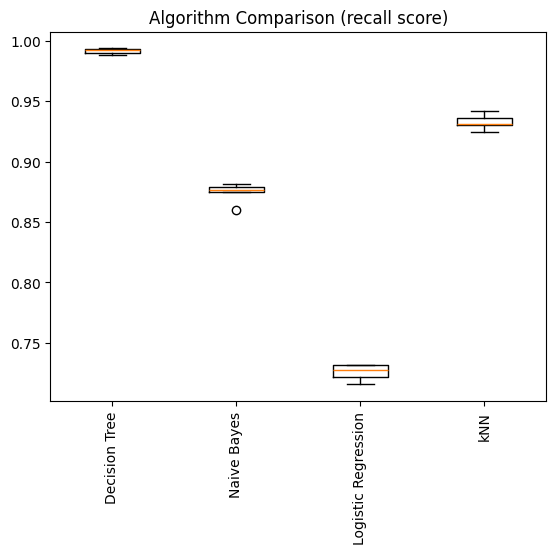

In [106]:
# With 10 features and Dealing with class imbalance with SMOTEENN-NearMiss and STRATIFIED 10-Fold CV
from imblearn.under_sampling import NearMiss
names = []
results = []
start_time = timeit.default_timer()

for name, classifier in classifiers1:
    sme = SMOTEENN(random_state=42)
    undersample = NearMiss(version=1, n_neighbors=3)
    accuracy = []
    recall = []
    precision = []
    f1 = []

    for train_index, test_index in StratifiedKFold(n_splits=10, shuffle=True).split(X_train, y_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # Apply SMOTE to the training data
        X_train_smote, y_train_smote = sme.fit_resample(X_train_cv, y_train_cv)
        X_train_comb, y_train_comb = undersample.fit_resample(X_train_smote, y_train_smote)
        start_train_time = time.time()
        classifier.fit(X_train_smote, y_train_smote)
        end_train_time = time.time()
        train_time = end_train_time - start_train_time
        print(f"{name} | Confusion Matrix:\n {confusion_matrix(y_test_cv, classifier.predict(X_test_cv))}")

        accuracy.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='accuracy'))
        recall.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='recall'))
        precision.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='precision'))
        f1.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='f1'))

    names.append(name)
    results.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='recall'))
    print(f"{name} | Training time: {train_time:.2f} seconds\n")

    print(f"{name} | Accuracy scores: {accuracy}")
    print(f"{name} | Mean accuracy: {np.mean(accuracy)} ({np.std(accuracy)})\n")
    print(f"{name} | Recall scores: {recall}")
    print(f"{name} | Mean recall: {np.mean(recall)} ({np.std(recall)})\n")
    print(f"{name} | Precision scores: {precision}")
    print(f"{name} | Mean precision: {np.mean(precision)} ({np.std(precision)})\n")
    print(f"{name} | F1 scores: {f1}")
    print(f"{name} | Mean F1: {np.mean(f1)} ({np.std(f1)})")
    print("=================================================\n")

# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison (recall score)')
plt.xticks(rotation=90)
plt.show()

Given the unsatisfactory results, we endeavor to improve by employing ensemble models with SMOTE and STRATIFIED 5-Fold Cross-Validation. We chose 5-fold for the more coputationally expensive models.

In [108]:
# 2---------------- With 10 features and Dealing with class imbalance with SMOTE and STRATIFIED 5-Fold CV
from imblearn.combine import SMOTEENN
names = []
results = []
start_time = timeit.default_timer()

for name, classifier in classifiers2:
    sme = SMOTEENN(random_state=42)
    accuracy = []
    recall = []
    precision = []
    f1 = []

    for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True).split(X_train, y_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # Apply SMOTE to the training data
        X_train_smote, y_train_smote = sme.fit_resample(X_train_cv, y_train_cv)
        
        start_train_time = time.time()
        classifier.fit(X_train_smote, y_train_smote)
        end_train_time = time.time()
        train_time = end_train_time - start_train_time
        print(f"{name} | Confusion Matrix:\n {confusion_matrix(y_test_cv, classifier.predict(X_test_cv))}")

        accuracy.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='accuracy'))
        recall.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='recall'))
        precision.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='precision'))
        f1.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='f1'))

    names.append(name)
    results.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='recall'))
    print(f"{name} | Training time: {train_time:.2f} seconds\n")

    print(f"{name} | Accuracy scores: {accuracy}")
    print(f"{name} | Mean accuracy: {np.mean(accuracy)} ({np.std(accuracy)})\n")
    print(f"{name} | Recall scores: {recall}")
    print(f"{name} | Mean recall: {np.mean(recall)} ({np.std(recall)})\n")
    print(f"{name} | Precision scores: {precision}")
    print(f"{name} | Mean precision: {np.mean(precision)} ({np.std(precision)})\n")
    print(f"{name} | F1 scores: {f1}")
    print(f"{name} | Mean F1: {np.mean(f1)} ({np.std(f1)})")
    print("=================================================\n")

# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison (recall score)')
plt.xticks(rotation=90)
plt.show()

Decision Tree | Confusion Matrix:
 [[2850   51]
 [  16    0]]
Decision Tree | Confusion Matrix:
 [[2881   20]
 [  15    1]]
Decision Tree | Confusion Matrix:
 [[2839   62]
 [  14    2]]
Decision Tree | Confusion Matrix:
 [[2869   32]
 [  15    1]]
Decision Tree | Confusion Matrix:
 [[2856   45]
 [  15    1]]
Decision Tree | Confusion Matrix:
 [[2865   36]
 [  15    0]]
Decision Tree | Confusion Matrix:
 [[2846   55]
 [  14    1]]
Decision Tree | Confusion Matrix:
 [[2854   46]
 [  16    0]]
Decision Tree | Confusion Matrix:
 [[2865   35]
 [  15    1]]
Decision Tree | Confusion Matrix:
 [[2862   38]
 [  16    0]]
Decision Tree | Training time: 0.41 seconds

Decision Tree | Accuracy scores: [array([0.99115789, 0.99221053, 0.99178947, 0.98884211, 0.99231498]), array([0.99367689, 0.99272842, 0.99420381, 0.99388766, 0.99388766]), array([0.99255557, 0.99149117, 0.99127845, 0.99085301, 0.99202297]), array([0.99240266, 0.99029229, 0.9909254 , 0.99176955, 0.99197974]), array([0.99069917, 0.9926

We repeat the steps for STRATIFIED 10-Fold Cross-Validation.

In [111]:
#2---------------------- With 10 features and Dealing with class imbalance with ADASYN and STRATIFIED 5-Fold CV
from imblearn.over_sampling import ADASYN
names = []
results = []
start_time = timeit.default_timer()

for name, classifier in classifiers2:
    ada = ADASYN(random_state=42)
    accuracy = []
    recall = []
    precision = []
    f1 = []

    for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True).split(X_train, y_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # Apply SMOTE to the training data
        X_train_ada, y_train_ada = ada.fit_resample(X_train_cv, y_train_cv)
        start_train_time = time.time()
        classifier.fit(X_train_ada, y_train_ada)
        end_train_time = time.time()
        train_time = end_train_time - start_train_time
        print(f"{name} | Confusion Matrix:\n {confusion_matrix(y_test_cv, classifier.predict(X_test_cv))}")

        accuracy.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='accuracy'))
        recall.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='recall'))
        precision.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='precision'))
        f1.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='f1'))

    names.append(name)
    results.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='recall'))
    print(f"{name} | Training time: {train_time:.2f} seconds\n")

    print(f"{name} | Accuracy scores: {accuracy}")
    print(f"{name} | Mean accuracy: {np.mean(accuracy)} ({np.std(accuracy)})\n")
    print(f"{name} | Recall scores: {recall}")
    print(f"{name} | Mean recall: {np.mean(recall)} ({np.std(recall)})\n")
    print(f"{name} | Precision scores: {precision}")
    print(f"{name} | Mean precision: {np.mean(precision)} ({np.std(precision)})\n")
    print(f"{name} | F1 scores: {f1}")
    print(f"{name} | Mean F1: {np.mean(f1)} ({np.std(f1)})")
    print("=================================================\n")

# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison (recall score)')
plt.xticks(rotation=90)
plt.show()

Decision Tree | Confusion Matrix:
 [[5641  161]
 [  27    4]]
Decision Tree | Confusion Matrix:
 [[5630  172]
 [  27    4]]
Decision Tree | Confusion Matrix:
 [[5637  164]
 [  21   11]]
Decision Tree | Confusion Matrix:
 [[5598  203]
 [  28    4]]
Decision Tree | Confusion Matrix:
 [[5643  158]
 [  24    8]]
Decision Tree | Training time: 0.10 seconds

Decision Tree | Accuracy scores: [array([0.99103809, 0.99306519, 0.99146394, 0.99146394, 0.99274434]), array([0.99103809, 0.99306519, 0.99146394, 0.99135723, 0.99242424]), array([0.99103809, 0.9929585 , 0.99146394, 0.99125053, 0.99274434]), array([0.99103809, 0.9929585 , 0.99146394, 0.99135723, 0.99242424]), array([0.99103809, 0.9929585 , 0.99146394, 0.99135723, 0.99274434])]
Decision Tree | Mean accuracy: 0.9918953470067923 (0.0007726685059015039)

Decision Tree | Recall scores: [array([0.98967621, 0.99460347, 0.99202065, 0.99037785, 0.99108191]), array([0.98967621, 0.99460347, 0.99202065, 0.99037785, 0.99178597]), array([0.98967621, 0.

KeyboardInterrupt: 

In [112]:
# With 10 features and Dealing with class imbalance with ADASYN-NearMiss and STRATIFIED 5-Fold CV
from imblearn.under_sampling import NearMiss
names = []
results = []
start_time = timeit.default_timer()

for name, classifier in classifiers2:
    sme = SMOTEENN(random_state=42)
    undersample = NearMiss(version=1, n_neighbors=3)
    accuracy = []
    recall = []
    precision = []
    f1 = []

    for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True).split(X_train, y_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # Apply SMOTE to the training data
        X_train_ada, y_train_ada = ada.fit_resample(X_train_cv, y_train_cv)
        X_train_comb, y_train_comb = undersample.fit_resample(X_train_ada, y_train_ada)
        start_train_time = time.time()
        classifier.fit(X_train_comb, y_train_comb)
        end_train_time = time.time()
        train_time = end_train_time - start_train_time
        print(f"{name} | Confusion Matrix:\n {confusion_matrix(y_test_cv, classifier.predict(X_test_cv))}")

        accuracy.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='accuracy'))
        recall.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='recall'))
        precision.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='precision'))
        f1.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='f1'))

    names.append(name)
    results.append(cross_val_score(classifier, X_train_smote, y_train_smote, scoring='recall'))
    print(f"{name} | Training time: {train_time:.2f} seconds\n")

    print(f"{name} | Accuracy scores: {accuracy}")
    print(f"{name} | Mean accuracy: {np.mean(accuracy)} ({np.std(accuracy)})\n")
    print(f"{name} | Recall scores: {recall}")
    print(f"{name} | Mean recall: {np.mean(recall)} ({np.std(recall)})\n")
    print(f"{name} | Precision scores: {precision}")
    print(f"{name} | Mean precision: {np.mean(precision)} ({np.std(precision)})\n")
    print(f"{name} | F1 scores: {f1}")
    print(f"{name} | Mean F1: {np.mean(f1)} ({np.std(f1)})")
    print("=================================================\n")

# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison (recall score)')
plt.xticks(rotation=90)
plt.show()

Decision Tree | Confusion Matrix:
 [[5632  170]
 [  23    8]]
Decision Tree | Confusion Matrix:
 [[5639  163]
 [  23    8]]
Decision Tree | Confusion Matrix:
 [[5649  152]
 [  27    5]]
Decision Tree | Confusion Matrix:
 [[5628  173]
 [  26    6]]
Decision Tree | Confusion Matrix:
 [[5635  166]
 [  29    3]]
Decision Tree | Training time: 0.12 seconds

Decision Tree | Accuracy scores: [array([0.99103809, 0.99306519, 0.99146394, 0.99146394, 0.99242424]), array([0.99103809, 0.99306519, 0.99146394, 0.99146394, 0.99274434]), array([0.99103809, 0.99306519, 0.99146394, 0.99125053, 0.99242424]), array([0.99103809, 0.99306519, 0.99146394, 0.99146394, 0.99274434]), array([0.99103809, 0.9929585 , 0.99146394, 0.99135723, 0.99242424])]
Decision Tree | Mean accuracy: 0.9918996141285215 (0.0007682048752269944)

Decision Tree | Recall scores: [array([0.98967621, 0.99460347, 0.99202065, 0.99037785, 0.99108191]), array([0.98967621, 0.99460347, 0.99202065, 0.99061253, 0.99108191]), array([0.98967621, 0.

KeyboardInterrupt: 

The following section is a mere template of what would follow had we concluded with a winning algorithm to classify our data.

## Model Training

In [145]:
# Hyperparameters

# GridSearch Classifiers
classifier = None # winning algorithm
grid_params = []  # hyperparameters to test for the winning algorithm

In [146]:
# Create the grid search object
tuned_clf = []

grid = GridSearchCV(classifier, grid_params, cv=10)

# Train the grid search
grid.fit(X_train_smote, y_train_smote)

# Best parameters
print(f"{name}: {grid.best_params_}")

# Best estimator
model_cc = grid.best_estimator_

Decision Tree: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5}
XGBoost: {'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 300}


## Model Finalisation

In [196]:
# Train the model on the training set - change training sets depending on the winning algorithm
model_cc.fit(X_train, y_train)

DecisionTreeClassifier()

In [249]:
y_pred = model_cc.predict(X_test)

Confusion Matrix:
 [[6530  722]
 [  33    7]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.90      0.95      7252
         1.0       0.01      0.17      0.02        40

    accuracy                           0.90      7292
   macro avg       0.50      0.54      0.48      7292
weighted avg       0.99      0.90      0.94      7292

Accuracy Score: 0.8964618760285245


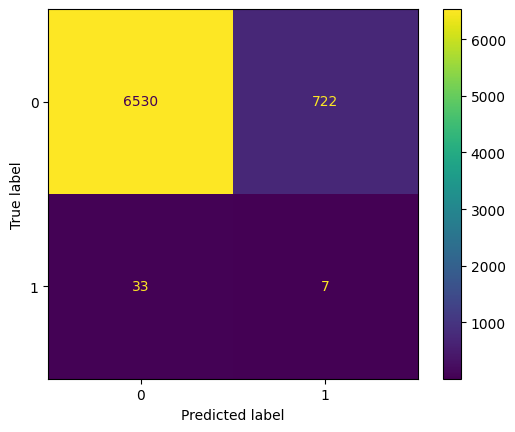

In [250]:
# Evaluate the model on the test set
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

In [ ]:
# Saving model as pickle for later use
joblib.dump(grid.best_estimator_, 'cc_approval.pkl')

## Prediction

In [ ]:
predictions = model_cc.predict(pred_df.risky) 
pred_df.iloc[pred_df.risky.isnull()] = predictions
pred_df.to_csv('NewCustomers_Predictions.csv', index=False)